In [1]:
import logging
import pyvista as pv

from pointcept.supplemental.utils import *
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    plot_mesh_folds,
    crop_meshes_per_fold,
    save_fold_meshes
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../../data")
label = 'rog_north'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
dh = DataHandler(label)
dh.ensure_meshes()

16:08:35 - INFO - Label rog_north does not currently have extracted meshes. Attempting now.
16:08:35 - INFO - Cleaning .bin extraction dirs.
16:08:35 - INFO - Splitting bin file ../../data/meshes/extracted/rog_north/rog_north.bin by category...
16:08:35 - INFO -   extracting category: 1_WALL
16:08:37 - INFO -   extracting category: 2_FLOOR
16:08:38 - INFO -   extracting category: 3_ROOF
16:08:40 - INFO -   extracting category: 4_CEILING
16:08:41 - INFO -   extracting category: 5_FOOTPATH
16:08:42 - INFO -   extracting category: 6_GRASS
16:08:43 - INFO -   extracting category: 7_COLUMN
16:08:43 - INFO -   extracting category: 8_DOOR
16:08:45 - INFO -   extracting category: 9_WINDOW
16:08:46 - INFO -   extracting category: 10_STAIR
16:08:47 - INFO -   extracting category: 11_RAILING
16:08:48 - INFO -   extracting category: 12_RWP
16:08:49 - INFO -   extracting category: 13_OTHER
16:08:50 - INFO -   converting 1_wall.bin
16:08:51 - INFO -   converting 2_floor.bin
16:08:51 - INFO -   conve

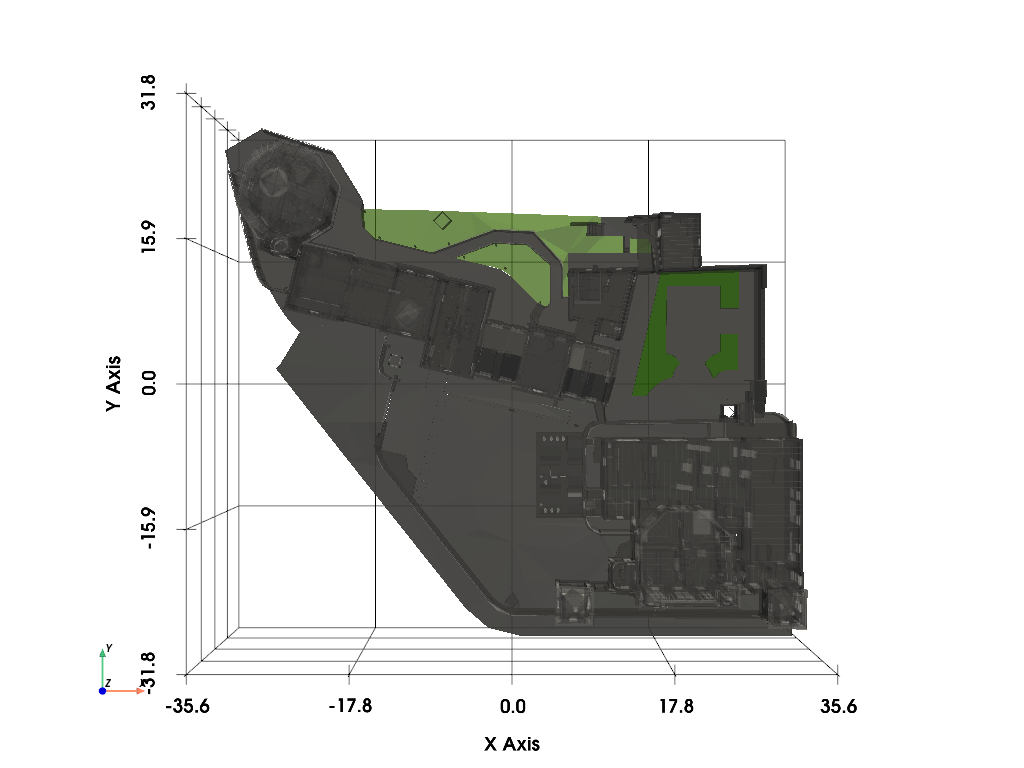

In [4]:
dh.plot_meshes()

In [5]:
analyser = MeshAnalyser(data_handler=dh)

In [6]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

16:09:21 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
16:09:21 - INFO - Sampling with resolution 0.15.
16:09:21 - INFO - Number of points after initial sampling: 3429335
16:09:23 - INFO - Number of points after Poisson Disk Sampling: 452953
16:09:23 - INFO - Number of points after initial sampling: 514710
16:09:24 - INFO - Number of points after Poisson Disk Sampling: 96977
16:09:24 - INFO - Number of points after initial sampling: 774622
16:09:24 - INFO - Number of points after Poisson Disk Sampling: 85875
16:09:24 - INFO - Number of points after initial sampling: 800157
16:09:24 - INFO - Number of points after Poisson Disk Sampling: 66098
16:09:24 - INFO - Number of points after initial sampling: 520125
16:09:24 - INFO - Number of points after Poisson Disk Sampling: 132001
16:09:24 - INFO - Number of points after initial sampling: 42102
16

In [32]:
binning = analyser.evaluate_binning(pcds, x_cell_width=4.0, y_cell_width=4.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

16:14:35 - INFO - Binning is using 18 bins in X and 16 bins in Y based on cell widths of 4.0 and 4.0.


16:15:55 - INFO - New best equality score: 62216.1311 at iteration 1
16:15:55 - INFO - New best equality score: 43524.7162 at iteration 13
16:15:56 - INFO - New best equality score: 40472.5633 at iteration 20
16:15:56 - INFO - New best equality score: 35278.2251 at iteration 37
16:15:57 - INFO - Number of unique seed cell configurations = 100


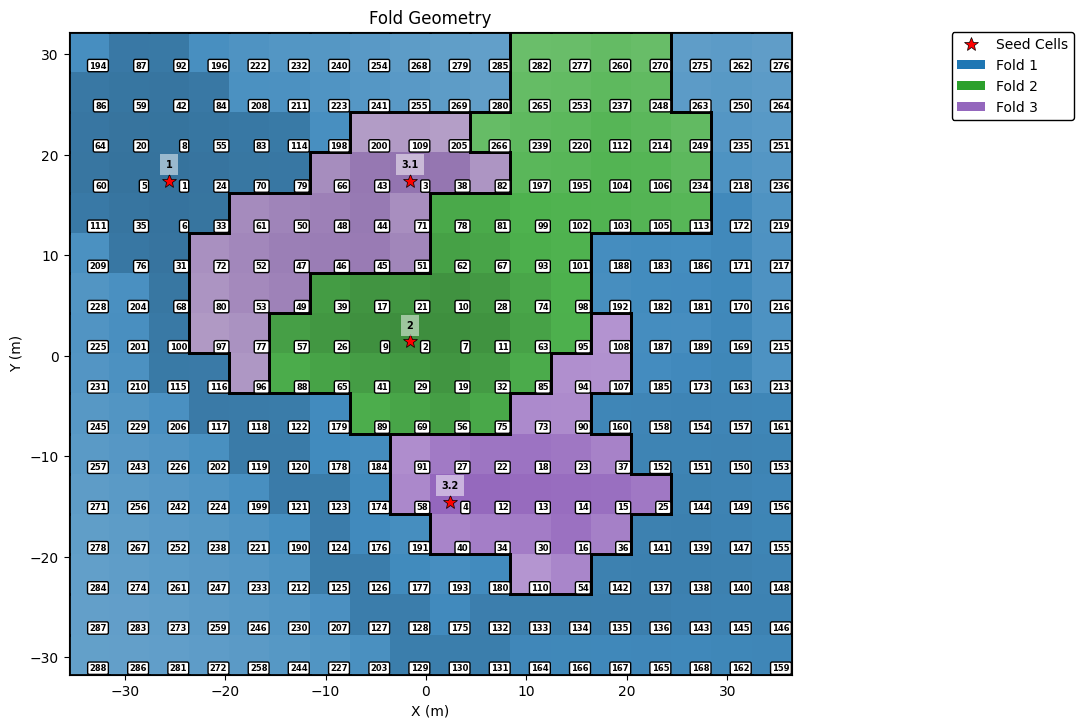

Iteration: 37

Fold Summaries:

Fold 1:
  Intended total counts: 618345.00
  Actual total counts: 527076.0
  Category Counts:
    1_WALL: 245964.0 (54.30% of total 1_WALL)
    2_FLOOR: 52522.0 (54.16% of total 2_FLOOR)
    3_ROOF: 47584.0 (55.41% of total 3_ROOF)
    4_CEILING: 39859.0 (60.30% of total 4_CEILING)
    5_FOOTPATH: 77585.0 (58.78% of total 5_FOOTPATH)
    6_GRASS: 3493.0 (29.54% of total 6_GRASS)
    8_DOOR: 6275.0 (62.01% of total 8_DOOR)
    9_WINDOW: 10134.0 (53.68% of total 9_WINDOW)
    10_STAIR: 3470.0 (41.44% of total 10_STAIR)
    11_RAILING: 12418.0 (60.74% of total 11_RAILING)
    12_RWP: 586.0 (51.58% of total 12_RWP)
    13_OTHER: 27186.0 (58.31% of total 13_OTHER)
  Aspect Ratio: 1.12

Fold 2:
  Intended total counts: 190260.00
  Actual total counts: 191976.0
  Category Counts:
    1_WALL: 99563.0 (21.98% of total 1_WALL)
    2_FLOOR: 19348.0 (19.95% of total 2_FLOOR)
    3_ROOF: 20168.0 (23.49% of total 3_ROOF)
    4_CEILING: 6638.0 (10.04% of total 4_CEILIN

In [52]:
weights = {1: 0.65, 2: 0.2, 3: 0.15}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 1, 3: 2}
iterations = 100  # Number of iterations to run

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)
grid_splitter.min_percentage_threshold = 8.0

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

16:16:35 - INFO - Fold 1, Region 1: Found 19 rectangles with total perimeter 218


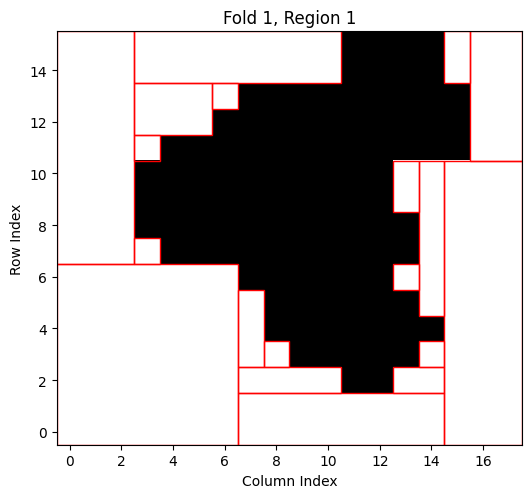

16:16:35 - INFO - Fold 2, Region 2: Found 9 rectangles with total perimeter 86


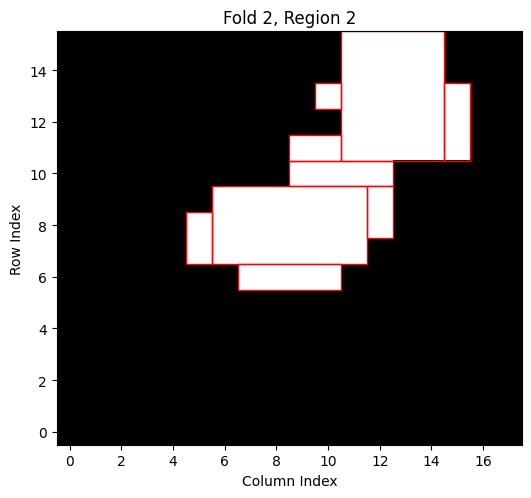

16:16:35 - INFO - Fold 3, Region 3: Found 8 rectangles with total perimeter 52


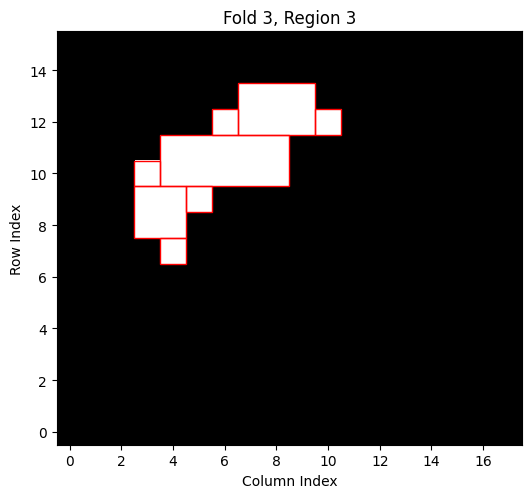

16:16:35 - INFO - Fold 3, Region 4: Found 7 rectangles with total perimeter 48


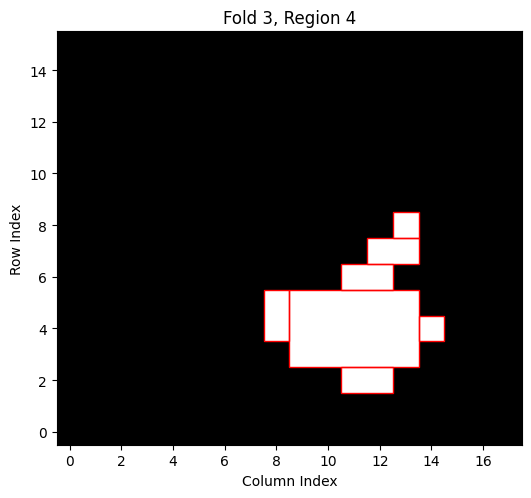

In [53]:
fold_rectangles = best_config.generate_fold_rectangles(combine_subregions=False)

In [ ]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    fold_rectangles,
    best_config.x_edges,
    best_config.y_edges,
)

16:16:35 - INFO - Processing Region 1 in Fold 1
16:17:16 - INFO - Processing Region 2 in Fold 2
16:17:34 - INFO - Processing Region 3 in Fold 3
16:17:53 - INFO - Processing Region 4 in Fold 3


In [ ]:
plot_mesh_folds(fold_meshes, backend='trame', cmap='tab20')

In [31]:
best_config.save(f"../../fold_allocations/{label}_v1.pkl")

In [7]:
save_fold_meshes(dh, fold_meshes)

02:00:41 - INFO - Saved Fold 1, Region 1, Category '1_WALL' to ../../data/meshes/extracted/rog_south/train/1_wall_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '2_FLOOR' to ../../data/meshes/extracted/rog_south/train/2_floor_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '3_ROOF' to ../../data/meshes/extracted/rog_south/train/3_roof_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '4_CEILING' to ../../data/meshes/extracted/rog_south/train/4_ceiling_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '5_FOOTPATH' to ../../data/meshes/extracted/rog_south/train/5_footpath_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '7_COLUMN' to ../../data/meshes/extracted/rog_south/train/7_column_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '8_DOOR' to ../../data/meshes/extracted/rog_south/train/8_door_sceneid1.ply.
02:00:41 - INFO - Saved Fold 1, Region 1, Category '9_WINDOW' to ../../data/meshes/e